# Controlling the MLSVD truncation 

One of the most important things one need to get right is the truncation of the MLSVD. It doesn't matter how optimized are the CPD routines, it will take a long time to finish the computations if the tensor is big and no compression is made. Many other CPD solvers out there skip the compression stage, and this is one of the reasons (but not the only one) why Tensor Fox is faster. In this lesson we will see some tricks to obtain a decent preprocessed tensor in which we will compute its CPD. Let's work again with the swimmer tensor.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import TensorFox as tfx

In [2]:
# Load the tensor T, which has shape 256 x 32 x 32. 
T = np.load('swimmer.npy')
m, n, p = T.shape
Tsize = np.linalg.norm(T)

Again, we will consider the rank as $R = 50$. As mentioned in lesson 3, the reduced MLSVD of $T$ is given by $T = (U_1, U_2, U_3) \cdot S$, where $S \in \mathbb{R}^{R_1 \times R_2 \times R_3}$, $U_1 \in \mathbb{R}^{256 \times R_1}$, $U_2 \in \mathbb{R}^{32 \times R_2}$, $U_3 \in \mathbb{R}^{32 \times R_3}$. The tuple $(R_1, R_2, R_3)$ is the multilinear rank of $T$. When the **cpd** function is called, its first action is to run a MLSVD routine and estimate the values $R_1, R_2, R_3$. Since these values are obtained by approximation, the resulting core tensor $S$ is actually a truncation. Below we run the **cpd** with $T$ to remember this.

In [3]:
# Compute the CPD of T, assuming T has rank 50. 
class options:
    display = 3
    
R = 50
factors, output = tfx.cpd(T, R, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compression detected
    Compressing from (256, 32, 32) to (13, 23, 15)
    Compression relative error = 2.024014e-10
-----------------------------------------------------------------------------------------------
Type of initialization: random
    Initial guess relative error = 1.396988e+00
-----------------------------------------------------------------------------------------------
Computing CPD
    Iteration | Rel error |  Step size  | Improvement | norm(grad) | Predicted error | # Inner iterations
        1     | 1.30e+00  |  4.18e-02   |  1.30e+00   |  2.72e+03  |    6.84e-03     |        2        
        2     | 1.27e+00  |  1.73e-02   |  3.32e-02   |  2.07e+03  |    1.73e-04     |        3        
        3     | 1.19e+00  |  4.92e-02   |  8.13e-02   |  1.82e+03  |    2.37e-04     |        3        
        4     | 1.04e+00  |  1.29e-01   |  1.54e-01   |  1.29e+

       86     | 5.49e-03  |  6.33e-03   |  1.48e-03   |  1.09e+01  |    6.23e-08     |        21       
       87     | 5.45e-03  |  1.61e-03   |  4.44e-05   |  8.03e-01  |    2.79e-08     |        12       
       88     | 5.42e-03  |  1.53e-03   |  2.40e-05   |  4.25e-01  |    5.10e-08     |        14       
       89     | 5.34e-03  |  8.71e-03   |  8.68e-05   |  9.99e-01  |    1.61e-07     |        23       
       90     | 5.26e-03  |  1.61e-03   |  7.66e-05   |  2.66e+00  |    1.89e-08     |        16       
       91     | 5.17e-03  |  1.38e-02   |  8.55e-05   |  8.40e-01  |    1.58e-07     |        22       
       92     | 4.98e-03  |  9.38e-03   |  1.96e-04   |  3.24e+00  |    3.24e-08     |        34       
       93     | 4.93e-03  |  2.75e-02   |  5.06e-05   |  1.61e+00  |    1.13e-07     |        51       
       94     | 4.48e-03  |  1.38e-02   |  4.50e-04   |  4.90e+00  |    4.60e-08     |        52       
       95     | 4.50e-03  |  3.29e-02   |  2.27e-05   |  2.62e+0

What we know for sure is that $R_1 \leq \min\{ R, m \}$, $R_2 \leq \min\{ R, n \}$, $R_3 \leq \min\{ R, p \}$. This is valid in general for order-$L$ tensors, i.e., $R_\ell \leq \min\{ R, I_\ell \}$ for all $\ell = 1 \ldots L$. For example, in the case of the swimmer tensor this tuple is $(50, 32, 32)$, but we just saw that the tuple $(13, 23, 15)$ is already very good (with error of order $10^{-10}$). This is a case where the "safe" tuple may be far away from the actual multilinear rank.

# Truncation testing 

In more difficult situations one may be interested in testing a list of several possible truncations and choose one of them. This can be accomplished with the function **test_truncation**. Below we show an example of usage with the swimmer tensor. Remember that an upper bound for the multilinear rank in this case is $(32, 32, 50)$. 

**PS:** Notice that the order of the dimensions are different here. The **cpd** function sorts the dimension of $T$ in descending order, so the original tensor with shape $32 \times 32 \times 256$ is rearranged to have shape $256 \times 32 \times 32$. The truncation testing doesn't change the dimensions order, so the optimal truncation $(13, 23, 15)$ mentioned before is for the sorted $T$. In this context the optimal truncation now is $(23, 15, 13)$. 

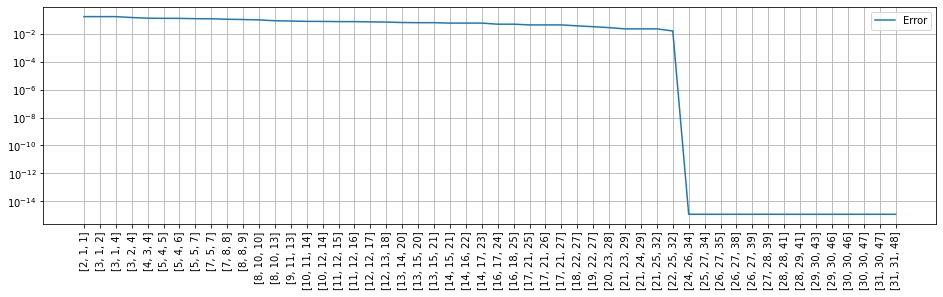

In [4]:
# List random of truncations in ascending order.
N = 60
R1_max, R2_max, R3_max = 32, 32, 50
R1_list = np.random.randint(1, R1_max, size=N)
R1_list = np.sort(R1_list)
R2_list = np.random.randint(1, R2_max, size=N)
R2_list = np.sort(R2_list)
R3_list = np.random.randint(1, R3_max, size=N)
R3_list = np.sort(R3_list)
trunc_list = [[R1_list[i], R2_list[i], R3_list[i]] for i in range(N)]

# Start the tests.
trunc_error = tfx.test_truncation(T, trunc_list, display=False)

# Now we plot the evolution of the energy and the corresponding errors.
trunc_str = [str(trunc_list[i]) for i in range(N)]

plt.figure(figsize=[16, 4])
plt.plot(trunc_str, trunc_error, label='Error')
plt.yscale('log')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

It may be not obvious but the reason for the big fall in the error comes from the first dimension, when it changes from $22$ to $23$. Below we make another test to verify this. Also, note that the second dimension doesn't need to be bigger than $21$ and the third dimension doesn't need to be bigger than $30$.

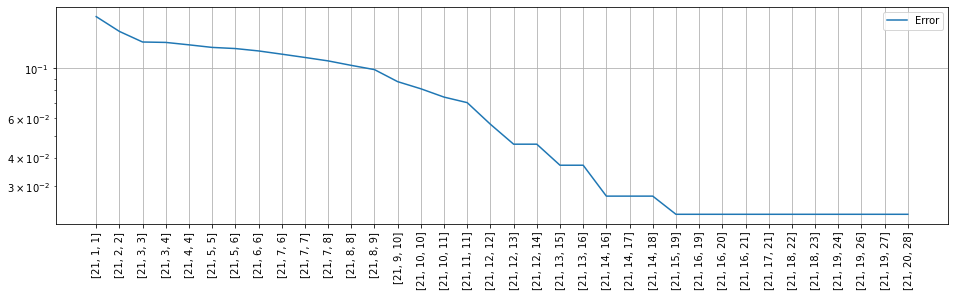

In [5]:
# List random of truncations in ascending order.
N = 60
R2_max, R3_max = 21, 30
R1_list = N*[21]
R1_list = np.sort(R1_list)
R2_list = np.random.randint(1, R2_max, size=N)
R2_list = np.sort(R2_list)
R3_list = np.random.randint(1, R3_max, size=N)
R3_list = np.sort(R3_list)
trunc_list = [[R1_list[i], R2_list[i], R3_list[i]] for i in range(N)]

# Start the tests.
trunc_error = tfx.test_truncation(T, trunc_list, display=False)

# Now we plot the evolution of the energy and the corresponding errors.
trunc_str = [str(trunc_list[i]) for i in range(N)]

# Errors
plt.figure(figsize=[16, 4])
plt.plot(trunc_str, trunc_error, label='Error')
plt.yscale('log')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

Although we can try several truncations to look for a good one, sometimes we have no clue about what truncation to test. Another possibility is, we are not interested in testing truncations but in finding the smallest one with more relative error smaller than a certain threshold. Maybe it is not the smallest one, but close to the smallest one is good enough. For this, it can be interesting to study how the truncations behave as a function of the $\verb|tol| \_ \verb|mlsvd|$. 